In [11]:
# base environment
import os
from collections import defaultdict, Counter
from timeit import default_timer as timer
from datetime import timedelta
import pandas as pd
import csv
import numpy as np
import random
import matplotlib.pyplot as plt

In [4]:
def read_tsv_file(file_path):
    """
    Read a TSV file and extract participant_id, scan_id, and age data.

    This function reads a TSV (Tab-Separated Values) file and extracts the relevant data, i.e., participant_id, scan_id, and age.
    
    Parameters:
        file_path (str): The path to the TSV file.

    Returns:
        list: A list of tuples, where each tuple contains the participant_id (str), scan_id (str), and age (float) for each entry in the TSV file.

    Example:
        >>> tsv_file_path = "path_to_your_tsv_file.tsv"
        >>> data = read_tsv_file(tsv_file_path)
        >>> print(data)
        [('sub-001', 'PS14_001', 'ses-001', 4.1389), ('sub-002', 'PS14_002', 'ses-001', 3.789), ...]
    """
    data = []
    with open(file_path, 'r') as file:
        header = file.readline()  # Skip the header line
        for line in file:
            participant_id, sub_id_bids, scan_id, session, age, sex, group = line.strip().split('\t')
            data.append((participant_id, scan_id, float(age)))
    return data

In [5]:
def find_intra_pairs(data):
    pairs = []
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            participant_id_1, scan_id_1, age_1 = data[i]
            participant_id_2, scan_id_2, age_2 = data[j]

            if participant_id_1 == participant_id_2:
                pairs.append(((participant_id_1, scan_id_1, age_1), (participant_id_2, scan_id_2, age_2)))

    return pairs

In [6]:
def find_inter_pairs(data):
    pairs = []
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            participant_id_1, scan_id_1, age_1 = data[i]
            participant_id_2, scan_id_2, age_2 = data[j]

            
            if participant_id_1 != participant_id_2:
                pairs.append(((participant_id_1, scan_id_1, age_1), (participant_id_2, scan_id_2, age_2)))
    
    return pairs

In [101]:
def find_inter_pairs_with_matching_distribution(data, age_intra_values):
    # Calculate histogram distribution of intra_array
    hist_distribution_intra, bin_edges_intra = np.histogram(age_intra_values, bins=25) # Mean: 1.152, std: 0.684

    # Known values for the new group
    inter_group_values = find_inter_pairs(data)
    age_inter_values = np.abs([item[0][2]-item[1][2] for item in inter_group_values])

    # Setting the seed
    seed_value = 42 
    random.seed(seed_value)

    # Suffle original age_inter_values list
    shuffled_age_inter_values = age_inter_values.copy()
    random.shuffle(shuffled_age_inter_values)
    

    num_samples = len(age_intra_values)
    age_inter_values_to_keep = []
    counter = 0
    for i, j, k in zip(bin_edges_intra, bin_edges_intra[1:], hist_distribution_intra):
        for inter_age_interval in shuffled_age_inter_values:
            if inter_age_interval >= i and inter_age_interval < j and counter < k and inter_age_interval not in age_inter_values_to_keep:
                age_inter_values_to_keep.append(inter_age_interval)
                counter += 1
            else:
                continue
        counter = 0

    plt.hist(age_inter_values_to_keep, range=(bin_edges_intra.min(), bin_edges_intra.max()), bins=25, alpha=0.5, label='Inter Group')
    plt.hist(age_intra_values, bins=25, alpha=0.5, label='Intra Group')
    plt.legend()
    plt.show()

    hist_distribution_inter, bin_edges_inter = np.histogram(age_inter_values_to_keep, range=(bin_edges_intra.min(), bin_edges_intra.max()), bins=25)
    print('hist_dist_inter \n')
    print(hist_distribution_inter,'\n')
    print('bin_edges_inter \n')
    print(bin_edges_inter,'\n')

    filtered_inter_values = []
    added_age_intervals = set()

    for item in inter_group_values:
        age_interval_diff = abs(item[0][2] - item[1][2])
        
        if age_interval_diff in age_inter_values_to_keep and age_interval_diff not in added_age_intervals:
            filtered_inter_values.append(item)
            added_age_intervals.add(age_interval_diff)
        
    return age_inter_values_to_keep, filtered_inter_values

    

In [44]:
def find_closest_values_with_indices(target_value, array):
    
    # Calculate the absolute differences between the target value and each element in the array
    differences = np.abs(array - target_value)
    
    # Find the indices of the two closest values
    closest_indices = np.argsort(differences)[:2]
    
    # Get the corresponding closest values
    closest_values = array[closest_indices]
    closest_values = sorted(closest_values)
    
    return closest_values, closest_indices[0]

In [49]:
def find_inter_pairs_with_matching_distribution_init(data, n_bins):
    # Calculate histogram distribution of intra_array
    intra_pairs_info = find_intra_pairs(data)
    intra_age_intervals = np.abs([item[0][2]-item[1][2] for item in intra_pairs_info])
    hist_distribution_intra_age_intervals, bin_edges_intra_age_intervals = np.histogram(intra_age_intervals, bins=n_bins) # Mean: 1.152, std: 0.684

    intra_init_ages = [min(item[0][2],item[1][2]) for item in intra_pairs_info]
    hist_distribution_intra_init_ages, bin_edges_intra_init_ages = np.histogram(intra_init_ages, bins=n_bins) # Mean: 1.152, std: 0.684


    # Known values for the new group
    inter_pairs_info = find_inter_pairs(data)
    inter_age_intervals = np.abs([item[0][2]-item[1][2] for item in inter_pairs_info])

    inter_init_ages = [min(item[0][2],item[1][2]) for item in inter_pairs_info]

    
    inter_pairs_to_keep = []
    # hist_distribution_inter_age_intervals = np.zeros(len(hist_distribution_intra_age_intervals))
    # hist_distribution_inter_init_ages = np.zeros(len(hist_distribution_intra_init_ages))
    # counter_intervals = 0
    # counter_init = 0
    for idx, intra_pair in enumerate(intra_pairs_info):
        limits_intervals, idx_bin_intervals  = find_closest_values_with_indices(intra_age_intervals[idx], bin_edges_intra_age_intervals)
        limits_init, idx_bin_init = find_closest_values_with_indices(intra_init_ages[idx], bin_edges_intra_init_ages)
        inter_set_age_intervals = set()
        inter_set_init_ages = set()
        # target_bin_count_intervals = hist_distribution_intra_age_intervals[idx_bin_intervals]
        # target_bin_count_init = hist_distribution_intra_init_ages[idx_bin_init]
        for idx, inter_pair in enumerate(inter_pairs_info):
            if inter_age_intervals[idx] >= limits_intervals[0] and inter_age_intervals[idx] < limits_intervals[1]:
                inter_set_age_intervals.add(inter_pair)
            if inter_init_ages[idx] >= limits_init[0] and inter_init_ages[idx] < limits_init[1]:
                inter_set_init_ages.add(inter_pair)
        
        # actual_bin_count_intervals = hist_distribution_inter_age_intervals[idx_bin_intervals]
        # actual_bin_count_init = hist_distribution_inter_init_ages[idx_bin_init]
        intersection = inter_set_age_intervals & inter_set_init_ages
        for element in intersection:

            if element not in inter_pairs_to_keep:
                inter_pairs_to_keep.append(element)

                break


    # for lim_inf_intervals, lim_sup_intervals, bin_count_intervals, lim_inf_init, lim_sup_init, bin_count_init in zip(bin_edges_intra_age_intervals, bin_edges_intra_age_intervals[1:], hist_distribution_intra_age_intervals, bin_edges_intra_init_ages, bin_edges_intra_init_ages[1:], hist_distribution_intra_init_ages):
    #     count_added = 0
    #     for idx, inter_pair in enumerate(inter_pairs_info):
    #         if inter_age_intervals[idx] >= lim_inf_intervals and inter_age_intervals[idx] < lim_sup_intervals:
    #             inter_set_age_intervals.add(inter_pair)
                
    #         if inter_init_ages[idx] >= lim_inf_init and inter_init_ages[idx] < lim_sup_init:
    #             inter_set_init_ages.add(inter_pair)
                
    #     intersection = inter_set_age_intervals & inter_set_init_ages
    #     for element in intersection:
    #         if element not in inter_pairs_to_keep and count_added <:
    #             count_added += 1
    #             inter_pairs_to_keep.append(element)
    #     counter_intervals = 0
    #     counter_init = 0

    inter_age_intervals_to_keep = np.abs([item[0][2]-item[1][2] for item in inter_pairs_to_keep])
    inter_init_ages_to_keep = [min(item[0][2],item[1][2]) for item in inter_pairs_to_keep]

    plt.hist(inter_age_intervals_to_keep, range=(bin_edges_intra_age_intervals.min(), bin_edges_intra_age_intervals.max()), bins=n_bins, alpha=0.5, label='Inter Group')
    plt.hist(intra_age_intervals, bins=n_bins, alpha=0.5, label='Intra Group')
    plt.legend()
    plt.show()

    plt.hist(inter_init_ages_to_keep, range=(bin_edges_intra_init_ages.min(), bin_edges_intra_init_ages.max()), bins=n_bins, alpha=0.5, label='Inter Group')
    plt.hist(intra_init_ages, bins=n_bins, alpha=0.5, label='Intra Group')
    plt.legend()
    plt.show()
        
    return inter_pairs_to_keep

    

In [14]:
len(age_intervals_intra)
print(np.mean(np.array(age_intervals_intra)), np.std(np.array(age_intervals_intra)))

1.15201866359447 0.6843657519819147


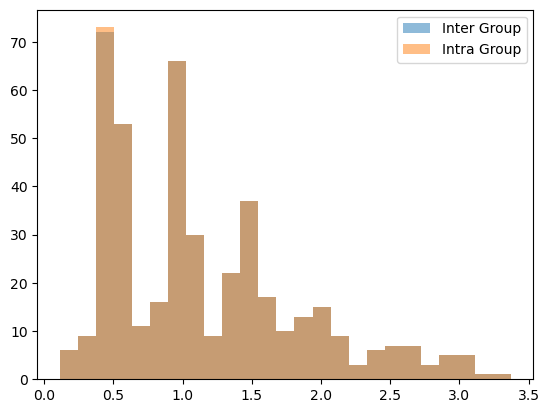

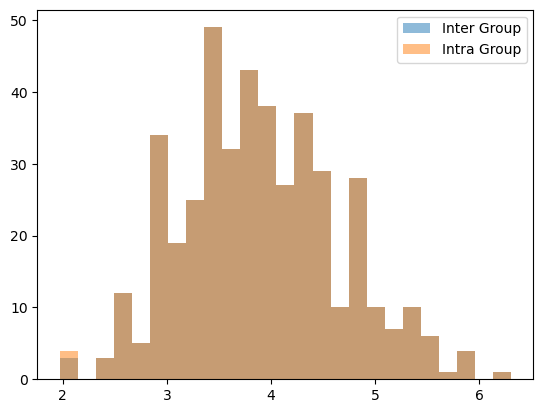

[(('10006', 'PS14_001', 4.1389), ('10094', 'PS16_044', 4.6889)), (('10049', 'PS14_117', 4.0694), ('10087', 'PS16_038', 5.0389)), (('10022', 'PS14_094', 4.175), ('10087', 'PS16_077', 5.5167)), (('10056', 'PS15_009', 4.125), ('10160', 'PS0579-10-1', 5.9972)), (('10022', 'PS15_049', 4.6361), ('10087', 'PS16_038', 5.0389)), (('10087', 'PS16_077', 5.5167), ('10110', 'PS16_071', 4.7222)), (('10053', 'PS16_049', 6.0444), ('10056', 'PS15_098', 4.6556)), (('10022', 'PS15_128', 5.1389), ('10083', 'PS16_051', 5.5389)), (('10006', 'PS14_120', 5.1389), ('10079', 'PS17_056', 6.0306)), (('10009', 'PS16_072', 5.4472), ('10010', 'PS16_046', 5.8444)), (('10007', 'PS14_121', 3.4722), ('10099', 'PS14_122', 3.875)), (('10009', 'PS14_070', 3.4333), ('10107', 'PS15_036', 4.3028)), (('10021', 'PS14_081', 3.8806), ('10083', 'PS15_053', 4.2722)), (('10020', 'PS15_032', 4.2694), ('10059', 'PS14_068', 3.8167)), (('10082', 'PS16_027', 5.4806), ('10104', 'PS16_003', 3.8722)), (('10118', 'PS15_079', 3.7889), ('10149

In [57]:
tsv_file_path = "all-participants.tsv"
data = read_tsv_file(tsv_file_path)

# Load the array from the file
age_intervals_intra = np.load('age_intervals_intra.npy')

target_distribution = age_intervals_intra  # Replace this with your actual distribution

# Call the function with the specified type and target_distribution
selected_pairs = find_inter_pairs_with_matching_distribution_init(data, n_bins=25)

# Print the selected pairs
print(selected_pairs)
print(len(selected_pairs))

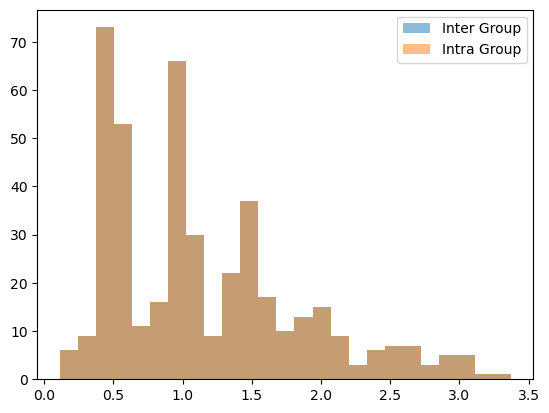

hist_dist_inter 

[ 6  9 73 53 11 16 66 30  9 22 37 17 10 13 15  9  3  6  7  7  3  5  5  1
  1] 

bin_edges_inter 

[0.1139   0.244232 0.374564 0.504896 0.635228 0.76556  0.895892 1.026224
 1.156556 1.286888 1.41722  1.547552 1.677884 1.808216 1.938548 2.06888
 2.199212 2.329544 2.459876 2.590208 2.72054  2.850872 2.981204 3.111536
 3.241868 3.3722  ] 

[(('10006', 'PS14_001', 4.1389), ('10008', 'PS14_046', 3.7306)), (('10006', 'PS14_001', 4.1389), ('10009', 'PS14_070', 3.4333)), (('10006', 'PS14_001', 4.1389), ('10014', 'PS15_051', 4.5556)), (('10006', 'PS14_001', 4.1389), ('10014', 'PS15_112', 5.0722)), (('10006', 'PS14_001', 4.1389), ('10014', 'PS16_030', 5.6278)), (('10006', 'PS14_001', 4.1389), ('10022', 'PS15_128', 5.1389)), (('10006', 'PS14_001', 4.1389), ('10022', 'PS16_036', 5.6667)), (('10006', 'PS14_001', 4.1389), ('10029', 'PS14_026', 3.5278)), (('10006', 'PS14_001', 4.1389), ('10046', 'PS17_009', 6.1722)), (('10006', 'PS14_001', 4.1389), ('10049', 'PS14_047', 3.6139)), (('

In [113]:
tsv_file_path = "all-participants.tsv"
data = read_tsv_file(tsv_file_path)

# Load the array from the file
age_intervals_intra = np.load('age_intervals_intra.npy')

target_distribution = age_intervals_intra  # Replace this with your actual distribution

# Call the function with the specified type and target_distribution
age_intervals_inter, selected_pairs = find_inter_pairs_with_matching_distribution(data, target_distribution)

# Print the selected pairs
print(selected_pairs)

In [114]:
age_intervals_intra

array([1.    , 1.0306, 1.9445, 1.4083, 0.575 , 1.4917, 0.5389, 0.5611,
       1.4277, 0.5778, 1.9723, 0.4972, 0.425 , 0.5167, 0.2639, 0.3666,
       0.4583, 0.4306, 1.1111, 1.0195, 0.4611, 1.125 , 1.875 , 1.4638,
       1.2083, 1.8361, 1.4611, 2.5833, 0.5389, 0.4861, 0.6472, 1.8417,
       2.0889, 1.4944, 1.0611, 0.5028, 0.4306, 1.3806, 0.45  , 0.4833,
       0.4028, 0.4555, 1.3778, 0.9028, 0.5   , 1.0083, 0.3972, 1.9889,
       1.1861, 0.8222, 1.7972, 0.5195, 0.5195, 2.6444, 1.7611, 2.125 ,
       0.4722, 0.9694, 3.0805, 1.8666, 0.1472, 1.8778, 0.9945, 0.5361,
       1.5556, 0.9972, 0.7639, 0.5889, 0.9527, 1.4527, 0.4722, 1.0333,
       1.0723, 1.0139, 2.8916, 1.5361, 0.8222, 1.4889, 2.7222, 0.1333,
       1.5888, 1.0666, 0.9833, 0.5556, 1.1167, 2.375 , 0.9583, 2.0028,
       3.0055, 0.4611, 1.2194, 1.    , 1.3694, 1.9972, 0.4972, 2.2278,
       0.5306, 1.2916, 0.9194, 1.4222, 1.3389, 1.1056, 0.5139, 1.3889,
       1.9111, 0.8944, 1.1083, 1.4722, 1.8972, 0.1584, 0.5   , 0.8778,
      

In [81]:
len(selected_pairs)

434

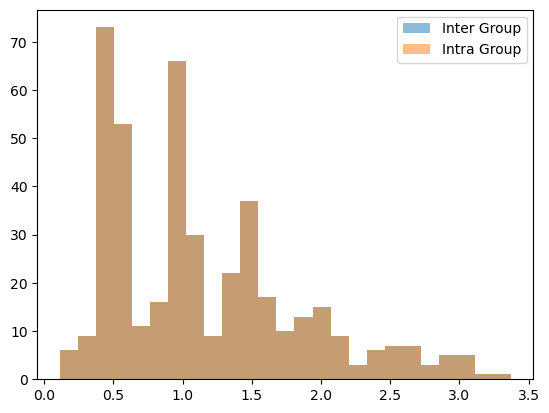

hist_dist_inter 

[ 6  9 73 53 11 16 66 30  9 22 37 17 10 13 15  9  3  6  7  7  3  5  5  1
  1] 

bin_edges_inter 

[0.1139   0.244232 0.374564 0.504896 0.635228 0.76556  0.895892 1.026224
 1.156556 1.286888 1.41722  1.547552 1.677884 1.808216 1.938548 2.06888
 2.199212 2.329544 2.459876 2.590208 2.72054  2.850872 2.981204 3.111536
 3.241868 3.3722  ] 

[(('10006', 'PS14_001', 4.1389), ('10008', 'PS14_046', 3.7306)), (('10006', 'PS14_001', 4.1389), ('10009', 'PS14_070', 3.4333)), (('10006', 'PS14_001', 4.1389), ('10014', 'PS15_051', 4.5556)), (('10006', 'PS14_001', 4.1389), ('10014', 'PS15_112', 5.0722)), (('10006', 'PS14_001', 4.1389), ('10014', 'PS16_030', 5.6278)), (('10006', 'PS14_001', 4.1389), ('10022', 'PS15_128', 5.1389)), (('10006', 'PS14_001', 4.1389), ('10022', 'PS16_036', 5.6667)), (('10006', 'PS14_001', 4.1389), ('10029', 'PS14_026', 3.5278)), (('10006', 'PS14_001', 4.1389), ('10046', 'PS17_009', 6.1722)), (('10006', 'PS14_001', 4.1389), ('10049', 'PS14_047', 3.6139)), (('

True

In [105]:
age_intervals_inter_2, selected_pairs_2 = find_inter_pairs_with_matching_distribution(data, target_distribution)
print(selected_pairs_2)
selected_pairs == selected_pairs_2

In [10]:
print(len(find_inter_pairs(data)))

38347


In [93]:
age_intervals_inter = []
for (participant_id_1, scan_id, age_interval) in selected_pairs:
    # Assuming each element is a list, you may need to adjust if they are strings
        age_intervals_inter.append(age_interval)
        

ValueError: not enough values to unpack (expected 3, got 2)

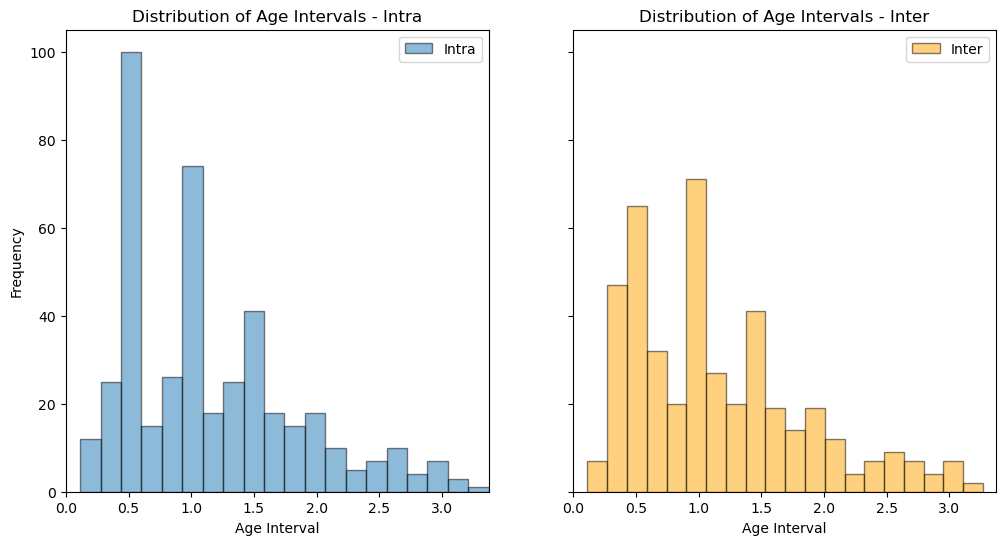

In [112]:
import matplotlib.pyplot as plt

# Assuming you have already calculated age_intervals_intra and age_intervals_inter

# Set up subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plotting histograms for Intra-group
hist1, bin_edges1, _ = ax1.hist(age_intervals_intra, bins=20, alpha=0.5, label='Intra', edgecolor='k')

# Adding labels and title for Intra-group
ax1.set_xlabel('Age Interval')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Age Intervals - Intra')
ax1.legend()

# Plotting histograms for Inter-group
hist2, bin_edges2, _ = ax2.hist(age_intervals_inter, bins=20, alpha=0.5, color='orange', label='Inter', edgecolor='k')

# Adding labels and title for Inter-group
ax2.set_xlabel('Age Interval')
ax2.set_title('Distribution of Age Intervals - Inter')
ax2.legend()

# Set the same xlim for both plots
max_xlim1 = max(bin_edges1)
max_xlim2 = max(bin_edges1)
max_xlim = max(max_xlim1, max_xlim2)
ax1.set_xlim(0, max_xlim)
ax2.set_xlim(0, max_xlim)

# Show the plot
plt.show()


In [4]:
from collections import defaultdict

# Open the TSV file for reading
with open('C:\\Users\\andje\\Documents\\Biomed\\Doctorat\\Projets\\intra-inter-classification\\src\\all-participants.tsv', 'r') as file:
    next(file)  # Skip the header line
    lines = file.readlines()

# Set to keep track of processed participant IDs
processed_participants = set()

# Total counts of 0s and 1s across all participants
total_counts = {'0': 0, '1': 0}

# Iterate through the lines of the file
for line in lines:
    fields = line.strip().split('\t')
    participant_id = fields[0]
    sex = fields[5]

    # Check if the participant has already been processed
    if participant_id not in processed_participants:
        # Count the occurrence of sex (0 or 1) for the participant
        total_counts[sex] += 1

        # Mark the participant as processed
        processed_participants.add(participant_id)

print(f"Total count of 0s: {total_counts['0']}, Total count of 1s: {total_counts['1']}")

Total count of 0s: 46, Total count of 1s: 50
